<a href="https://colab.research.google.com/github/KordingLab/Neural_Decoding/blob/classifiers/central_concepts_in_ML_for_decoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decoding neural activity
_Machine learning for mind reading_

This tutorial introduces concepts that are central to the practice of decoding neural activity using machine learning (or any method). We will make heavy use of our [Python package for neural decoding](https://github.com/KordingLab/Neural_Decoding).

This tutorial accompanies these [lecture slides](https://).

The solutions to the exercises can be found in [this completed Colab](https://colab.research.google.com/drive/1SxXwmTgW2Ro34BQEy91zOXHs9JhMqcBJ).

### Outline

1. Overfitting
2. Crossvalidation
3. Regularization
4. Applying recurrent neural networks
5. What methods work best and when?

## Preliminaries

Import modules and simulate data

In [32]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
from scipy.signal import windows
import pickle
import pathlib as pl
from sklearn import linear_model
from sklearn import model_selection

try:
    from bayes_opt import BayesianOptimization
except ImportError:
    print("\nWARNING: BayesianOptimization package is not installed. You will be unable to use section 4.")
    pass

# If you would prefer to load the '.h5' example file rather than the '.pickle' example file. You need the deepdish package
# import deepdish as dd 

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history
from Neural_Decoding.preprocessing_funcs import bin_spikes
from Neural_Decoding.preprocessing_funcs import bin_output

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import WienerCascadeDecoder
from Neural_Decoding.decoders import WienerFilterDecoder
from Neural_Decoding.decoders import DenseNNDecoder
from Neural_Decoding.decoders import SimpleRNNDecoder
from Neural_Decoding.decoders import GRUDecoder
from Neural_Decoding.decoders import LSTMDecoder
from Neural_Decoding.decoders import XGBoostDecoder
from Neural_Decoding.decoders import SVRDecoder

#Turn off deprecation warnings

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# folder='' #ENTER THE FOLDER THAT YOUR DATA IS IN
# folder='/home/jglaser/Data/DecData/' 
folder=pl.Path(r'Z:\Emilio\SuperiorColliculusExperiments\Roller\Batch2_ephys\MC\GAD18\211205_C\ephys_F\\')
#folder=pl.Path(r'Z:\Emilio\Decoding\\')
folder=folder.as_posix()

#with open(folder+'/example_data_s1.pickle','rb') as f:
with open(folder+'/GADi18_decode_sync.pickle','rb') as f:
    #spike_times,vels,unitID,fr,fs,vel_times=pickle.load(f,encoding='latin1') #If using python 3
    neural_data,vels_binned,unitID,fr,fs=pickle.load(f,encoding='latin1') #If using python 3
fs = float(fs)
n_neurons = 59

In [31]:
vels_binned.shape

(131648, 1)

In [63]:
## Standarising data
X_mean = np.nanmean(neural_data, axis=0)
X_std = np.nanstd(neural_data, axis=0, ddof=1)
X = stats.zscore(neural_data, axis=0)
y = stats.zscore(vels_binned, axis=0)

splitter = model_selection.TimeSeriesSplit(n_splits=5)

# Fitting and testing
for train_idx, test_idx in splitter.split(X):
    X_train, X_test = X[train_idx,:], X[test_idx,:]
    y_train, y_test = y[train_idx], y[test_idx]
    
    normal_GLM = linear_model.TweedieRegressor(power=0, link='identity', max_iter=500)
    normal_GLM.fit(X_train, y_train.flatten())
    print('GLM',normal_GLM.score(X_test, y_test.flatten()))
    
    lin_mod = linear_model.LinearRegression()
    lin_mod.fit(X_train, y_train)
    print('Linear', lin_mod.score(X_test, y_test))
    

GLM -0.032562353452253445
Linear -0.02876337984240096
GLM -78.61401817939078
Linear -178.26070660227376
GLM -21.945834006042947
Linear -55.535839974636595
GLM -1.3982032928059644
Linear -3.734998349641911
GLM -0.005948532494824299
Linear -0.015400100371380177


In [68]:
def wc_evaluate(degree):
    model_wc=WienerCascadeDecoder(degree) #Define model
    model_wc.fit(X_train,y_train) #Fit model
    y_valid_predicted_wc=model_wc.predict(X_test) #Validation set predictions
    return np.mean(get_R2(y_test,y_valid_predicted_wc)) #R2 value of validation set (mean over x and y position/velocity)

wcBO = BayesianOptimization(wc_evaluate, {'degree': (1, 7)}, verbose=1)

In [69]:
wcBO.maximize(init_points=5, n_iter=5, kappa = 10)    

|   iter    |  target   |  degree   |
-------------------------------------
|  4        | -0.005882 |  4.78     |


IndexError: tuple index out of range

(-0.2, 0.1)

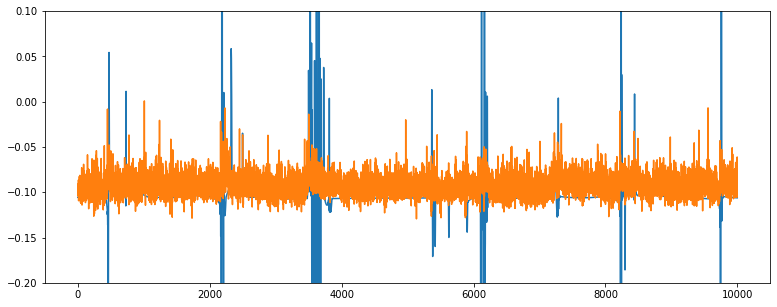

In [36]:
plt.figure(figsize= (13, 5))
plt.plot(y[100000:110000])
plt.plot(normal_GLM.predict(X[100000:110000,:]))
plt.ylim(-0.2, 0.1)